In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#For random forest for time series:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#For metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFE

#For multiprocessing further down
import multiprocessing

#For timing stuff
import time

In [2]:
num_cores = multiprocessing.cpu_count()
print(num_cores)

num_cores = 4

4


In [3]:
def loadSeries(datatype=None,house=None,rename=None, shifts=None):
    '''
    Loading data series from cf_filled (consumption) or pf_filled (production)
    
    datatype: str, specifies whether the production or consumption values are selected
              
              "Production", "Consumption", "P", "C", "prod", "cons", etc.
    
    
    house: str, specifies which house is selected 
           
           "k28", "h16", "h22", "h28", or "h32"
         
    rename: str, renames chosen column. 
            
            If the whole file is returned, this parameter is ignored
            
    shifts: list of int, if given, specifies what shifted columns to add
    '''
    res = None
    #Production or consumption string stuff
    datatypeStr = ""
    if datatype is None:
        raise Exception("First input must specify either Production or Consumption")
    elif datatype[0].lower()=="p":
        datatypeStr = "prod_"
    elif datatype[0].lower()=="c":
        datatypeStr = "cons_"
    
    #Making sure an existing house is chosen
    if house is None:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    
    #Production or consumption is chosen and loaded
    if datatypeStr=="prod_":
        res = pd.read_csv("pf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    else:
        res = pd.read_csv("cf_filled.csv",sep=",")
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    
    #Renaming value column
    if not house is None and not rename is None:
        res = res.rename(columns={datatypeStr+house: rename}, errors="raise")
    
    #Shifted columns added
    if not shifts is None:
        if rename is None:
            shiftname = 't'
        else:
            shiftname = rename
        dataframe = pd.DataFrame()
        for i in shifts:
           dataframe[shiftname + '-' + str(i)] = res.shift(i)
        res = pd.concat([res, dataframe], axis=1)
        res.dropna(inplace=True)
    
    #Nice stuff for indexing
    res['Year']=res.index.year
    res['Month']=res.index.month
    res['Day']=res.index.day
    res['Weekday']=res.index.weekday
    res['Hour']=res.index.hour
    return res

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

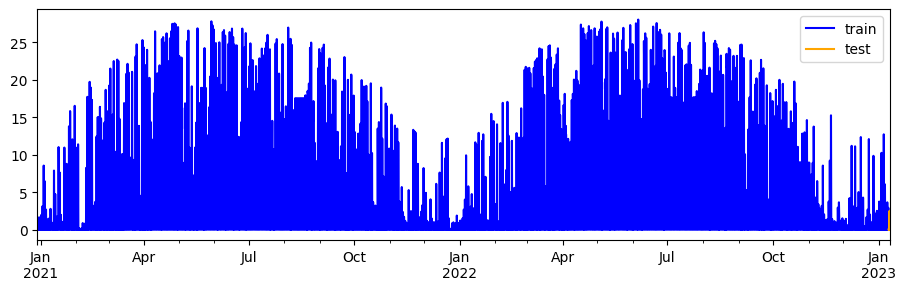

,val,val-24,val-48,val-168,Year,Month,Day,Weekday,Hour
2020-12-29 00:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,0
2020-12-29 01:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,1
2020-12-29 02:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,2
2020-12-29 03:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,3
2020-12-29 04:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,4
...,...,...,...,...,...,...,...,...,...
2021-02-08 11:00:00+00:00,0.4,0.4,0.3,7.7,2021,2,8,0,11
2021-02-08 12:00:00+00:00,0.3,0.4,0.9,15.1,2021,2,8,0,12
2021-02-08 13:00:00+00:00,0.6,0.4,1.1,7.7,2021,2,8,0,13
2021-02-08 14:00:00+00:00,0.8,0.5,0.6,7.5,2021,2,8,0,14


In [4]:
train_series = loadSeries("p","h16","val", [24,48,24*7])
units_to_forecast = 24

train = train_series[:-units_to_forecast]
test = train_series[-units_to_forecast:]

fig, ax=plt.subplots(figsize=(11, 3))
moving_average(train['val'], 3).plot(ax=ax, label='train', color='blue')
moving_average(test['val'], 1).plot(ax=ax, label='test', color='orange')
ax.legend();
plt.show()
train_series.head(1000)

## Hyperparameter tuning

In [6]:
forecaster = ForecasterAutoreg(
                regressor = RFE(RandomForestRegressor(random_state=123, n_jobs=num_cores), n_features_to_select=4),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [1,2]

# Regressor's hyperparameters
param_grid = {'estimator__n_estimators': [i for i in range(60,72,2)],
              'estimator__max_depth': [i for i in range(8,10,1)]}
start = time.time()
results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = train_series[24*365-3024:24*365]['val'],
                            exog               = train_series[24*365-3024:24*365].drop(['val'], axis=1),
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = units_to_forecast,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(3000),
                            return_best        = True,
                            fixed_train_size   = True,
                            verbose            = False
                   )
end = time.time()
print("Searching took {}s".format(end-start))
results_grid

Number of models compared: 24


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:43<00:00, 21.67s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'estimator__max_depth': 8, 'estimator__n_estimators': 64}
  Backtesting metric: 0.053387904643046546

Searching took 44.70887756347656s


,lags,params,metric,estimator__max_depth,estimator__n_estimators
2,[1],"{'estimator__max_depth': 8, 'estimator__n_esti...",0.053388,8,64
3,[1],"{'estimator__max_depth': 8, 'estimator__n_esti...",0.053440,8,66
4,[1],"{'estimator__max_depth': 8, 'estimator__n_esti...",0.053521,8,68
5,[1],"{'estimator__max_depth': 8, 'estimator__n_esti...",0.053764,8,70
0,[1],"{'estimator__max_depth': 8, 'estimator__n_esti...",0.053807,8,60
1,[1],"{'estimator__max_depth': 8, 'estimator__n_esti...",0.053927,8,62
8,[1],"{'estimator__max_depth': 9, 'estimator__n_esti...",0.055976,9,64
6,[1],"{'estimator__max_depth': 9, 'estimator__n_esti...",0.057520,9,60
9,[1],"{'estimator__max_depth': 9, 'estimator__n_esti...",0.057567,9,66
11,[1],"{'estimator__max_depth': 9, 'estimator__n_esti...",0.057795,9,70


In [11]:
start = time.time()
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = train_series[24*365:24*365+3024]['val'],
                            exog       = train_series[24*365:24*365+3024].drop(['val'], axis=1),
                            initial_train_size = 3000,
                            steps      = units_to_forecast,
                            refit      = True,
                            interval   = [5/2, 100-5/2],
                            n_boot     = 500,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
end = time.time()
print("Training took {}s".format(end-start))
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 3000
Number of observations used for backtesting: 24
    Number of folds: 1
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2021-12-29 00:00:00+00:00 -- 2022-05-02 23:00:00+00:00
    Validation: 2022-05-03 00:00:00+00:00 -- 2022-05-03 23:00:00+00:00

Training took 164.17147040367126s


,pred,lower_bound,upper_bound
2022-05-03 00:00:00+00:00,0.006616,-2.145869,2.498572
2022-05-03 01:00:00+00:00,0.006616,-2.278856,2.689656
2022-05-03 02:00:00+00:00,0.006616,-2.707541,3.203455
2022-05-03 03:00:00+00:00,0.006616,-2.094750,3.005713


['lag_1', 'val-24', 'val-48', 'Hour']


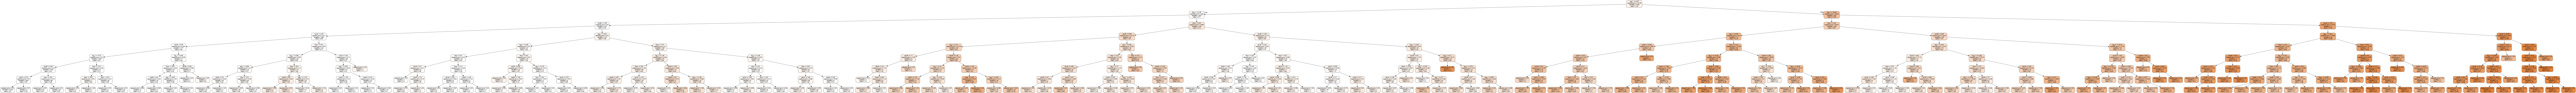

In [13]:
#Stolen from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

estimator = forecaster.regressor.estimator_.estimators_[5]

y = train_series[24*365-3024:24*365]['val']

names = list(forecaster.regressor.get_feature_names_out())
print(names)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = names,
                class_names = y,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')